In [1]:
## This script is to plot average precipitation of selected days vs no selected days
## dates selection based on RAINFALL_AREA_ANALYSIS_01
## Created by C. Bayu Risanto, S.J. (31 March 2025)
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from numpy import matlib
import os
from os.path import exists
import xarray as xr
import dateutil.parser
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mplotcolors
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from copy import copy
import shapely.geometry as sgeom
from datetime import date, datetime, timedelta
# create ncfile opener
def read_nc(link,ncfile):
    fname = link + ncfile
    ds = xr.open_dataset(fname)
    pcp = ds.PRECIP[:,:,:]
    return pcp
def read_latlon(link,ncfile):
    fname = link + ncfile
    ds = xr.open_dataset(fname)
    lat = ds.lat_0[:]
    lon = ds.lon_0[:]
    return lat,lon
def date_range_list(start_date, end_date):
    # Return list of datetime.date objects (inclusive) between start_date and end_date (inclusive).
    date_list = []
    curr_date = start_date
    while curr_date <= end_date:
        date_list.append(curr_date)
        curr_date += timedelta(days=1)
    return date_list

In [2]:
## create day times
daystrform = '%Y-%m-%d'
dayPivot = datetime.strptime('2021-07-01',daystrform)
dayEnd   = datetime.strptime('2021-09-11',daystrform)
dayList = [dayPivot.strftime(daystrform)]
while dayPivot < dayEnd:
    dayPivot += timedelta(days=1)
    dayList.append(dayPivot.strftime(daystrform))
dayList = np.asarray(dayList)

## make LOOP of datetime string here
accul = []
for itime in range(len(dayList)-1):
    day_st = str(dayList[itime])
    day_en = str(dayList[itime + 1])
    datestrform = '%Y-%m-%dT%H'
    date_st = datetime.strptime(day_st + 'T18',datestrform)
    date_en = datetime.strptime(day_en + 'T12',datestrform)
    dateList = [date_st.strftime(datestrform)]
    date_time = date_st
    while date_time < date_en:
        date_time += timedelta(hours=1)
        dateList.append(date_time.strftime(datestrform))
    dateList = np.asarray(dateList)

    ## Crop 
    min_lat = 31.2
    max_lat = 37
    min_lon = 245
    max_lon = 251

    ## hourly precip and save the dates and hours
    link = '/home/bayu/DATA/ARIZONA_PRO/OBS/MRMS/ncfiles/'
    pcp_hr_al = []
    for i in range(len(dateList)):
        yy = str(dateList[i]); YYYY = yy[0:4]
        mm = str(dateList[i]); MM = mm[5:7]
        dd = str(dateList[i]); DD = dd[8:10]
        hh = str(dateList[i]); HH = hh[11:13]
        nc_hour = 'MultiSensor_QPE_01H_Pass2_00.00_'+YYYY+MM+DD+'-'+HH+'0000_AZ.nc'
        if exists(link + nc_hour) == True:
            pcp_hr = read_nc(link,nc_hour)
            new = pcp_hr.sel(lat_0=slice(min_lat,max_lat),lon_0=slice(min_lon,max_lon)) ##crop here
            pcp_hr_al.append(np.squeeze(new))
        else:
            new = np.ndarray((580, 600)) # empty matrix with columns
            new[:] = np.nan
            pcp_hr_al.append(new)
    al_pcp_hr = np.asarray(pcp_hr_al)
    ## accum precipt
    pcp_tot = np.sum(al_pcp_hr,axis=0) 
    accul.append(pcp_tot)

pcp_al = np.asarray(accul)

In [3]:
## make LOOP of datetime string here
AREAX = []
ACCUM = []

for itime in range(72):
    day_st = str(dayList[itime])
    day_en = str(dayList[itime + 1])
    datestrform = '%Y-%m-%dT%H'
    date_st = datetime.strptime(day_st + 'T18',datestrform)
    date_en = datetime.strptime(day_en + 'T12',datestrform)
    dateList = [date_st.strftime(datestrform)]
    date_time = date_st
    while date_time < date_en:
        date_time += timedelta(hours=1)
        dateList.append(date_time.strftime(datestrform))
    dateList = np.asarray(dateList)

    ## Crop 
    min_lat = 31.2
    max_lat = 37
    min_lon = 245
    max_lon = 251

    ## hourly precip and save the dates and hours
    link = '/home/bayu/DATA/ARIZONA_PRO/OBS/MRMS/ncfiles/'
    pcp_hr_al = []
    for i in range(len(dateList)):
        yy = str(dateList[i]); YYYY = yy[0:4]
        mm = str(dateList[i]); MM = mm[5:7]
        dd = str(dateList[i]); DD = dd[8:10]
        hh = str(dateList[i]); HH = hh[11:13]
        nc_hour = 'MultiSensor_QPE_01H_Pass2_00.00_'+YYYY+MM+DD+'-'+HH+'0000_AZ.nc'
        if exists(link + nc_hour) == True:
            pcp_hr = read_nc(link,nc_hour)
            new = pcp_hr.sel(lat_0=slice(min_lat,max_lat),lon_0=slice(min_lon,max_lon)) ##crop here
            pcp_hr_al.append(np.squeeze(new))
    al_pcp_hr = np.asarray(pcp_hr_al)

    ## accum precipt
    pcp_tot = np.sum(al_pcp_hr,axis=0) 

    ## precip threshold
    thr = 5        ## in mm
    dist = 111     ## km equival to 1 degree
    ix = np.where(pcp_tot >= thr)
    area = len(ix[0]) * (0.01 * dist)**2 

    ## find the highest value of the precip grid point
    mx = pcp_tot.max()
    AREAX.append(area); ACCUM.append(mx)

In [4]:
## correction
dayINT = ['2021-07-03', '2021-07-09', '2021-07-10', '2021-07-12', '2021-07-13', 
          '2021-07-14', '2021-07-15', '2021-07-16', '2021-07-18', '2021-07-21', 
          '2021-07-22', '2021-07-23', '2021-07-24', '2021-07-25', '2021-07-29', 
          '2021-07-30', '2021-08-10', '2021-08-11', '2021-08-13', '2021-08-15', 
          '2021-08-16', '2021-08-30', '2021-08-31', '2021-09-01']

ixdate = [np.where(dayList == dayINT[i]) for i in range(len(dayINT))]

dayList_cp = dayList[0:-1]
mask=np.full(len(dayList_cp),True,dtype=bool)
mask[ixdate]=False
y=dayList_cp[mask]
z=dayList_cp[~mask]
nxdate = [np.where(dayList_cp == y[i]) for i in range(len(y))]

In [5]:
## grab the events
events = np.squeeze(pcp_al[ixdate,:,:])
nevent = np.squeeze(pcp_al[nxdate,:,:])
print(events.shape, nevent.shape)

(24, 580, 600) (48, 580, 600)


In [6]:
## get the average
m_events = np.nanmean(events,axis=0)
m_nevent = np.nanmean(nevent,axis=0)

## read lat lon
lat,lon = read_latlon(link,'MultiSensor_QPE_01H_Pass2_00.00_20210902-040000_AZ.nc')
xlon = np.matlib.repmat(lon,len(lat),1) - 360.
xlat = np.matlib.repmat(lat,len(lon),1).T
## crop lat lon
lat_c = lat.sel(lat_0=slice(min_lat,max_lat))
lon_c = lon.sel(lon_0=slice(min_lon,max_lon))
xlon_c = np.matlib.repmat(lon_c,len(lat_c),1) - 360.
xlat_c = np.matlib.repmat(lat_c,len(lon_c),1).T

In [7]:
## get contour hgt
ds = xr.open_dataset('/home/bayu/DATA/ARIZONA_PRO/metadata/HGT_d01.nc')
HGT = ds.HGT[0,:,:]
XLAT = ds.XLAT[0,:,:]
XLON = ds.XLONG[0,:,:]

## get rid of anything less than 0 m
HGT = HGT.where(HGT >= 1)

In [8]:
xticks = np.arange(-114.,-108,2)
yticks = np.arange(31.,38.,1)
## create background
crs = ccrs.PlateCarree()
def plot_background(ax):
    ax.set_extent([-115.,-109.,31.,37.5], ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'),linewidth=1.4,zorder=3)
    #ax.add_feature(cfeature.BORDERS,linestyle=':',linewidth=0.7,zorder=3)
    ax.add_feature(cfeature.STATES,linestyle=':',linewidth=0.7,zorder=3)
    ax.set_xticks(xticks, crs=ccrs.PlateCarree())
    ax.set_yticks(yticks, crs=ccrs.PlateCarree())
    ax.set_xticklabels(xticks, rotation=0, fontsize=12)
    ax.set_yticklabels(yticks, rotation=0, fontsize=12)
    ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.contour(XLON,XLAT,HGT,6,vmin=0,vmax=2500,colors='k',linewidths=0.6)
    
    gl = ax.gridlines(ccrs.PlateCarree(),draw_labels=False,linewidth=2,color='gray',
                     alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.xlabels_bottom = False
    gl.ylabels_left = False
    gl.ylabels_right = False
    gl.xlines = False; gl.ylines = False
    gl.xlocator = mticker.FixedLocator(xticks)
    gl.ylocator = mticker.FixedLocator(yticks)

    ax.contour(XLON,XLAT,HGT,6,vmin=0,vmax=2500,colors='k',linewidths=0.6)
    ## get star over TUCSON and PHOENIX
    lat_TUS = 32.25
    lon_TUS = -110.97 
    ax.plot(lon_TUS,lat_TUS, marker='*',markerfacecolor='none', markeredgecolor='k', markersize=14, transform=projection)
    lat_PHX = 33.48
    lon_PHX = -112.07
    ax.plot(lon_PHX,lat_PHX, marker='*',markerfacecolor='none', markeredgecolor='k', markersize=14, transform=projection)
    lat_PCT = 34.54
    lon_PCT = -112.46
    ax.plot(lon_PCT,lat_PCT, marker='*',markerfacecolor='none', markeredgecolor='k', markersize=14, transform=projection)
    lat_FGS = 35.1983
    lon_FGS = -111.6513
    ax.plot(lon_FGS,lat_FGS, marker='*',markerfacecolor='none', markeredgecolor='k', markersize=14, transform=projection)
    
    return ax

In [9]:
# create Precip color
pcp_colors = ['#ffffff','#00eeee','#00b2ee','#1e90ff','#104e8b',
             '#7fff00','#00cd00','#008b00','#ffff00','#ffd700',
             '#cd8500','#ff7f00','#ee4000','#cd0000','#8b0000',
             '#ffaeb9','#8968cd','#912cee','#8b008b']

varval     = [0., 1, 2, 3, 5, 10, 15, 20, 25, 30, 35,
               40, 45, 50, 60, 70, 80, 90, 100, 150]

precip_cmap = mplotcolors.ListedColormap(pcp_colors,'precipitation')
adjnorm = mplotcolors.BoundaryNorm(varval,precip_cmap.N) 

var_hr = [0.,1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 
          18, 20, 22, 24, 26, 30]
precip_hr = mplotcolors.ListedColormap(pcp_colors,'precip_hr')
adjnorm_hr = mplotcolors.BoundaryNorm(var_hr,precip_hr.N)

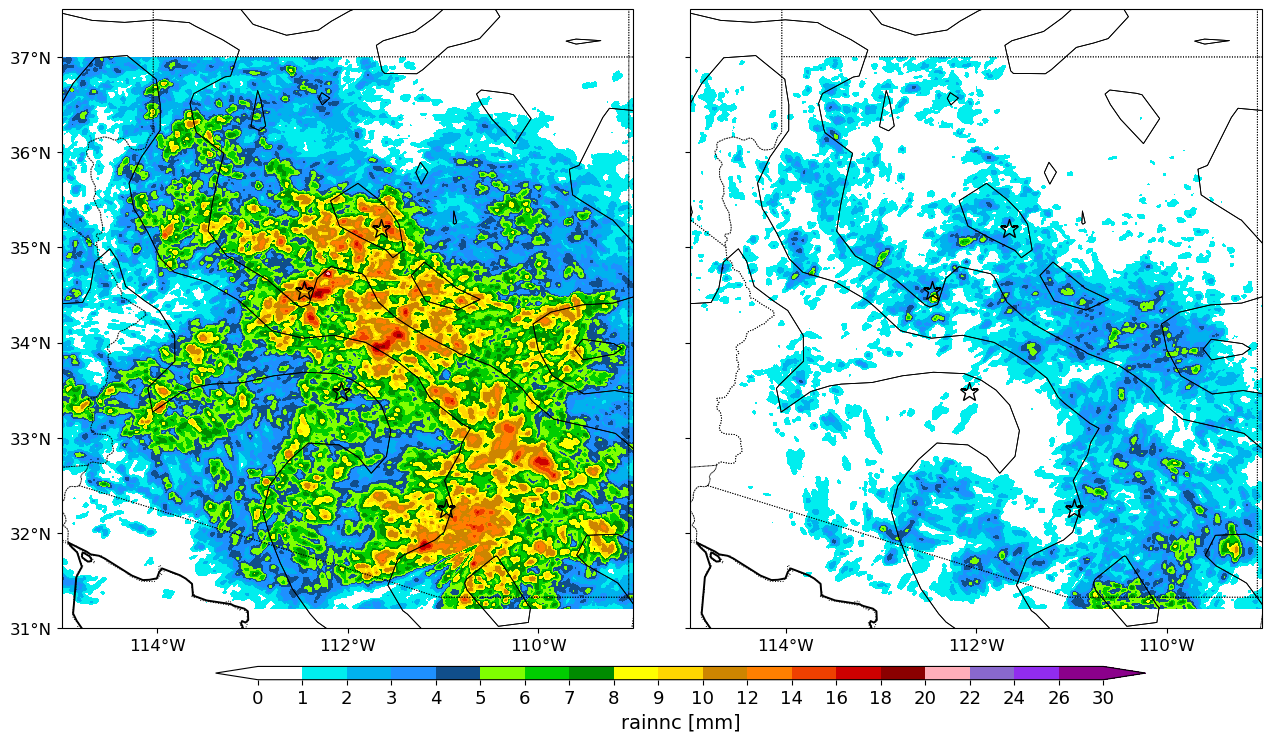

In [10]:
###########################################
# Plot #           
###########################################
projection = ccrs.PlateCarree()
fig, axe = plt.subplots(1, 2, figsize=(15, 10),
                                   subplot_kw={'projection': projection})
## AX1
axlist = axe.flatten()
for ax1 in axlist:
    plot_background(ax1)
    p0 = axlist[0].contourf(xlon_c,xlat_c,m_events,
                           var_hr,cmap=precip_hr,norm=adjnorm_hr,extend='both',transform=projection,) 
    p1 = axlist[1].contourf(xlon_c,xlat_c,m_nevent,
                           var_hr,cmap=precip_hr,norm=adjnorm_hr,extend='both',transform=projection,)
    axlist[1].set_yticklabels([])

#Add precip colorbar
cbar0 = fig.colorbar(p0,ticks=var_hr,ax=axe,orientation='horizontal',
                    shrink=0.8,aspect=70,pad=0.01,anchor=(0.5,-0.6))
cbar0.ax.tick_params(labelsize=13)
cbar0.set_label('rainnc [mm]',fontsize=14)

#fig.tight_layout()
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace= 0.0)

plt.show()
plt.close()

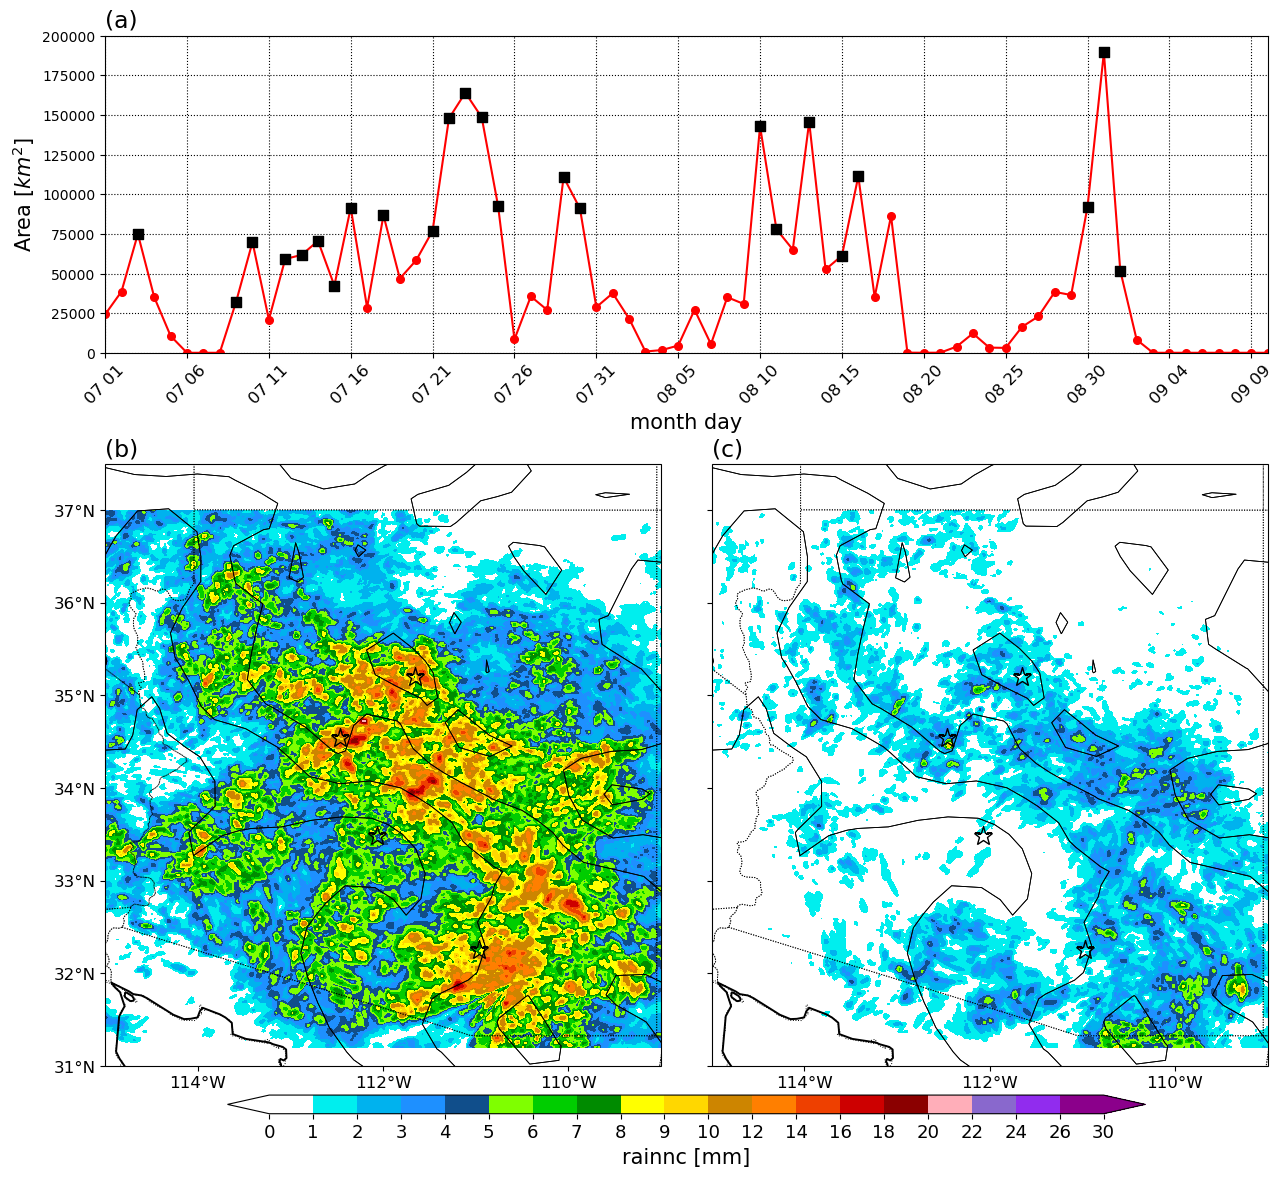

In [13]:
###########################################
# Plot all the plots combined          
###########################################
## create time
st_time = datetime.fromisoformat('2021-07-01')
en_time = datetime.fromisoformat('2021-09-10')
tt1 = date_range_list(st_time,en_time)
msz = 5.5

projection = ccrs.PlateCarree()

# Placing the plots in the plane
fig = plt.figure(figsize=(15,14))
plot1 = plt.subplot2grid((3, 4), (0, 0), colspan=4,)
plot2 = plt.subplot2grid((3, 4), (1, 0), rowspan=3, colspan=2,projection=projection)
plot3 = plt.subplot2grid((3, 4), (1, 2), rowspan=3, colspan=4, projection=projection)
#plot4 = plt.subplot2grid((3, 4), (2, 0), colspan=4,)

########plot1.plot(x, np.exp(x))
AREAX2 = np.asarray(AREAX); tt2 = np.asarray(tt1)
plot1.scatter(tt2[ixdate],AREAX2[ixdate],c='black',marker='s',s=50,zorder=4)
plot1.plot(tt1,AREAX,'r',marker='o',markersize=msz)
plot1.grid(color='black', linestyle='dotted')
plot1.set_ylabel('Area [$km^2$]',fontsize=15)
plot1.set_xlabel('month day',fontsize=15)
plot1.set_title('(a)',fontsize=17,loc='left')
plot1.xaxis.set_major_formatter(mdates.DateFormatter('%m %d'))
plot1.tick_params(axis='x',labelrotation=45,labelsize=12)
plot1.set_xlim([tt1[0], tt1[-1]]); 
plot1.set_ylim(0,200000)
plot1.xaxis.set_major_locator(mdates.DayLocator(interval=5))

plot_background(plot2)
p2 = plot2.contourf(xlon_c,xlat_c,m_events,
                           var_hr,cmap=precip_hr,norm=adjnorm_hr,extend='both',transform=projection,)
plot2.set_title('(b)',fontsize=17,loc='left')

plot_background(plot3)
plot3.contourf(xlon_c,xlat_c,m_nevent,
                           var_hr,cmap=precip_hr,norm=adjnorm_hr,extend='both',transform=projection,)
plot3.set_title('(c)',fontsize=17,loc='left')
plot3.set_yticklabels([])

###Add precip colorbar
#cbar0 = fig.colorbar(p2,ticks=var_hr,ax=plot4,orientation='horizontal',shrink=0.8,aspect=70,pad=0.01,)
gs = gridspec.GridSpec(
    3, 10,
    height_ratios=[1,1,0.04],
    ) 
gs.update(wspace= 1)
cbar0 = fig.colorbar(p2,ticks=var_hr,cax=plt.subplot(gs[-1,1:-1]),orientation='horizontal',shrink=0.8,aspect=40,)

cbar0.ax.tick_params(labelsize=13)
cbar0.set_label('rainnc [mm]',fontsize=15)

## SAVE
dir_out = '/home/bayu/PLOTS/ARIZONA_PRO/Potential_Cases/RAIN_TOTAL/'
plotfile  = 'RAIN_AREA-MRMS_3plots.png'
sf = fig.savefig(dir_out+plotfile, dpi=300, bbox_inches='tight')

plt.show()
plt.close()

In [45]:
print(gs)

GridSpec(3, 10, height_ratios=[1, 1, 0.05])
